(demo2022-07-11)=
# Demo Notebook 2022-07-11

Demos from the live sessions on 2022-07-11.


## Setup



In [1]:
import grama as gr
import pandas as pd
import numpy as np
DF = gr.Intention()
%matplotlib inline


In [2]:
# NOTE: No need to edit; load the archival data
filename_archival = "../challenges/data/doe-wide.csv"
df_archival = pd.read_csv(filename_archival)
df_archival.head()

,d,n,f_com,H,W,M_max,mass,dMdtheta_avs,dMdtheta_0,M_min,BM,angle,int_M_stable,GM
0,0.414694,0.969522,0.384112,1.931260,1.390651,5.004726e-16,0.019592,NaN,-1.459991,-4.952630,0.108234,NaN,-8.019885,0.193949
1,0.242507,1.195436,0.656740,2.713299,3.580954,7.277457e+00,0.046730,NaN,9.916728,-5.402567,0.425216,NaN,3.675911,-0.557773
2,0.441223,0.936345,0.672138,1.446188,3.744617,6.550768e+00,0.040910,8.237037,-11.668754,-5.879390,1.073773,1.617128,-5.681558,0.768485
3,0.689483,0.882652,0.648739,1.210221,2.530339,1.149756e+00,0.034526,2.380926,-8.409095,-2.228434,0.764303,1.509121,-2.070254,0.652657
4,0.497305,0.780804,0.235978,2.502149,1.505777,7.886234e-16,0.029039,NaN,-8.644337,-14.019720,0.103794,NaN,-25.533024,0.796536


## Correlation tile plot

Since there are `NaN` values in our dataset `df_archival`, we need to handle them somehow. We can use the `nan_drop=True` option in `gr.tf_iocorr()` to simply drop the `NaN`'s when computing correlations.


Calling plot_corrtile....


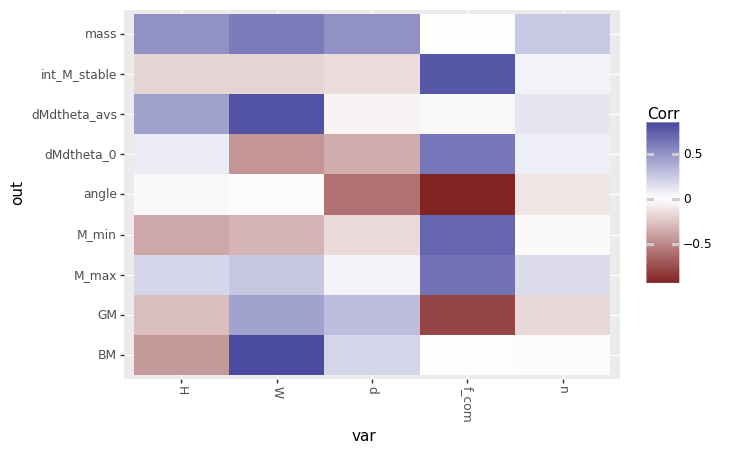

<ggplot: (8760894671336)>

In [3]:
var = ["d", "n", "f_com", "H", "W"]
out = [
    "M_max", 
    "M_min", 
    "mass", 
    "dMdtheta_avs", 
    "dMdtheta_0", 
    "BM", 
    "GM",
    "angle",
    "int_M_stable",
]

(
    df_archival
    >> gr.tf_iocorr(
        var=var, 
        out=out, 
        nan_drop=True,
    )
    >> gr.pt_auto()
)

From this plot, we can see that the correlation between `H` and `dMdtheta_0` is small, as is the correlation between `n` and `dMdtheta_0`. This suggests that the *linear* relationship between the two is quite small. But keep in mind that a nonlinear relationship could also exist.

We can also trim the `out` argument to produce a more focused plot:


Calling plot_corrtile....


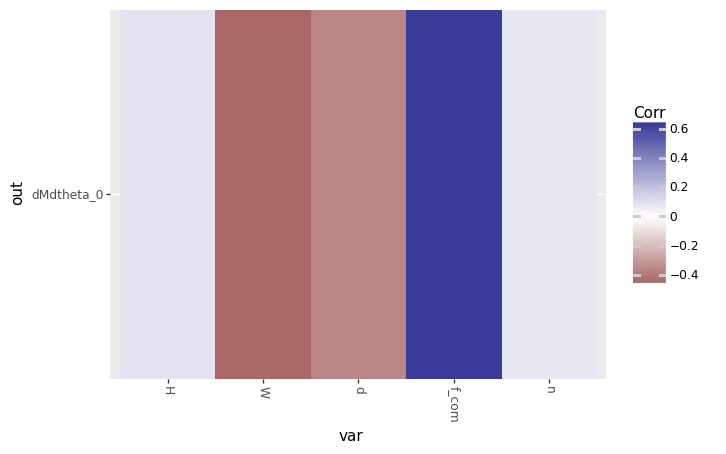

<ggplot: (8760914488950)>

In [4]:
(
    df_archival
    >> gr.tf_iocorr(
        var=var, 
        out=["dMdtheta_0"],
        nan_drop=True,
    )
    >> gr.pt_auto()
)

A plot like this looks somewhat strange. Really, we only have five numbers, so we might as well just look at the table of values:


In [5]:
(
    df_archival
    >> gr.tf_iocorr(
        var=var, 
        out=["dMdtheta_0"],
        nan_drop=True,
    )
    >> gr.tf_arrange(DF.rho)
)

,rho,var,out
0,-0.424045,W,dMdtheta_0
1,-0.336092,d,dMdtheta_0
2,0.074710,n,dMdtheta_0
3,0.089236,H,dMdtheta_0
4,0.611931,f_com,dMdtheta_0


## Detailed Scatterplot

Here's how I incorporate multiple scatterplots into a single figure. Pivoting the data allows me to use faceting.


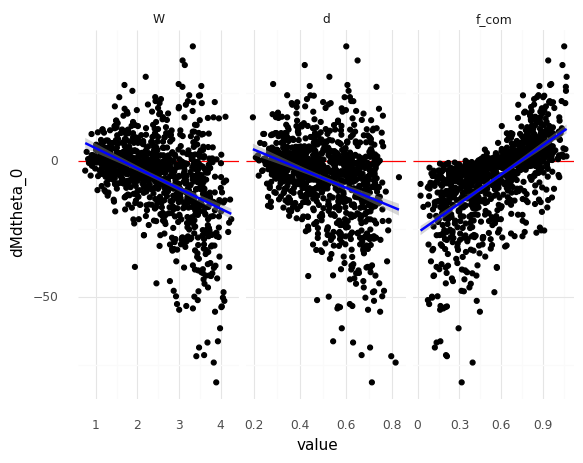

<ggplot: (8760835732209)>

In [6]:
(
    df_archival
    >> gr.tf_select(
        "dMdtheta_0",
        "W",
        "d",
        "f_com"
    )
    >> gr.tf_pivot_longer(
        columns=["W", "d", "f_com"],
        names_to="var",
        values_to="value",
    )
    
    >> gr.ggplot(gr.aes("value", "dMdtheta_0"))
    + gr.geom_hline(yintercept=0, color="red")
    + gr.geom_point()
    + gr.geom_smooth(color="blue")
    + gr.facet_grid("~var", scales="free_x")
    + gr.theme_minimal()
)

## Plotting quantiles


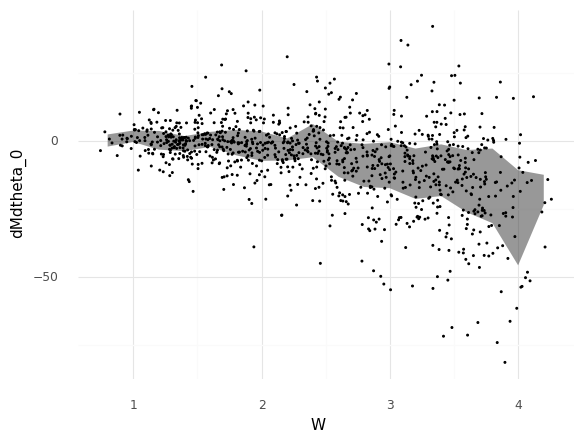

<ggplot: (8760881143866)>

In [23]:
factor = 1/2
(
    df_archival
    
    >> gr.ggplot(gr.aes("W", "dMdtheta_0"))
    + gr.geom_ribbon(
        data=df_archival
        >> gr.tf_mutate(W_bin=gr.round(DF.W*factor, decimals=1)/factor)
        >> gr.tf_group_by(DF.W_bin)
        >> gr.tf_summarize(
            ymin=gr.quant(DF.dMdtheta_0, 0.25),
            dMdtheta_0=gr.mean(DF.dMdtheta_0),
            ymax=gr.quant(DF.dMdtheta_0, 0.75),
        ),
        mapping=gr.aes(x="W_bin", ymin="ymin", ymax="ymax"),
        alpha=2/4,
    )
    + gr.geom_point(size=0.2)
    + gr.theme_minimal()
)

## Targeted Sinew Plot

Note that `gr.pt_auto()` calls other plotting functions with default arguments. We can call the same function with different arguments to tweak a visual. For instance, we can plot a smaller number of outputs for a more focused plot:

```python
## Targeting a single output
(
    df_sinews
    >> gr.pt_sinew_outputs(
        var=["W", "H", "d", "f_com", "n"],
        out=["dMdtheta_0"],
    )
)

## Targeting a couple inputs
(
    df_sinews
    >> gr.pt_sinew_outputs(
        var=["d", "f_com"],
        out=["dMdtheta_0"],
    )
)

## Manually constructing a single sweep (over W)
(
    df_sinews
    >> gr.tf_filter(DF.sweep_var == "W")
    
    >> gr.ggplot(gr.aes("W", "dMdtheta_0"))
    + gr.geom_line(gr.aes(color="factor(sweep_ind)"))
)

```
